In [1]:
import sys
import requests
import tarfile
import json
import numpy as np
import os
from os import path
from PIL import Image
from PIL import ImageFont, ImageDraw
from glob import glob
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
fname = 'examples.tar.gz'
url = 'https://dax-cdn.cdn.appdomain.cloud/dax-publaynet/1.0.0/' + fname
r = requests.get(url)
open(fname , 'wb').write(r.content)

6461141

In [3]:
tar = tarfile.open(fname)
tar.extractall()
tar.close()

In [4]:
colors = {'title': (255, 0, 0),
          'text': (0, 255, 0),
          'figure': (0, 0, 255),
          'table': (255, 255, 0),
          'list': (0, 255, 255)}

In [5]:
def markup(image, annotations):
    ''' Draws the segmentation, bounding box, and label of each annotation
    '''
    draw = ImageDraw.Draw(image, 'RGBA')
    for annotation in annotations:
        # Draw segmentation
        draw.polygon(annotation['segmentation'][0],
                     fill=colors[samples['categories'][annotation['category_id'] - 1]['name']] + (64,))
        # Draw bbox
        draw.rectangle(
            (annotation['bbox'][0],
             annotation['bbox'][1],
             annotation['bbox'][0] + annotation['bbox'][2],
             annotation['bbox'][1] + annotation['bbox'][3]),
            outline=colors[samples['categories'][annotation['category_id'] - 1]['name']] + (255,),
            width=2
        )
        # Draw label
        w, h = draw.textsize(text=samples['categories'][annotation['category_id'] - 1]['name'],
                             font=font)
        if annotation['bbox'][3] < h:
            draw.rectangle(
                (annotation['bbox'][0] + annotation['bbox'][2],
                 annotation['bbox'][1],
                 annotation['bbox'][0] + annotation['bbox'][2] + w,
                 annotation['bbox'][1] + h),
                fill=(64, 64, 64, 255)
            )
            draw.text(
                (annotation['bbox'][0] + annotation['bbox'][2],
                 annotation['bbox'][1]),
                text=samples['categories'][annotation['category_id'] - 1]['name'],
                fill=(255, 255, 255, 255),
                font=font
            )
        else:
            draw.rectangle(
                (annotation['bbox'][0],
                 annotation['bbox'][1],
                 annotation['bbox'][0] + w,
                 annotation['bbox'][1] + h),
                fill=(64, 64, 64, 255)
            )
            draw.text(
                (annotation['bbox'][0],
                 annotation['bbox'][1]),
                text=samples['categories'][annotation['category_id'] - 1]['name'],
                fill=(255, 255, 255, 255),
                font=font
            )
    return np.array(image)

In [6]:
with open('examples/samples.json', 'r') as fp:
    samples = json.load(fp)
# Index images
images = {}
for image in samples['images']:
    images[image['id']] = {'file_name': "examples/" + image['file_name'], 'annotations': []}
for ann in samples['annotations']:
    images[ann['image_id']]['annotations'].append(ann)

<ipython-input-7-a06e4e60ba57>:6: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = plt.subplot(len(images) / 2, 2, i + 1)


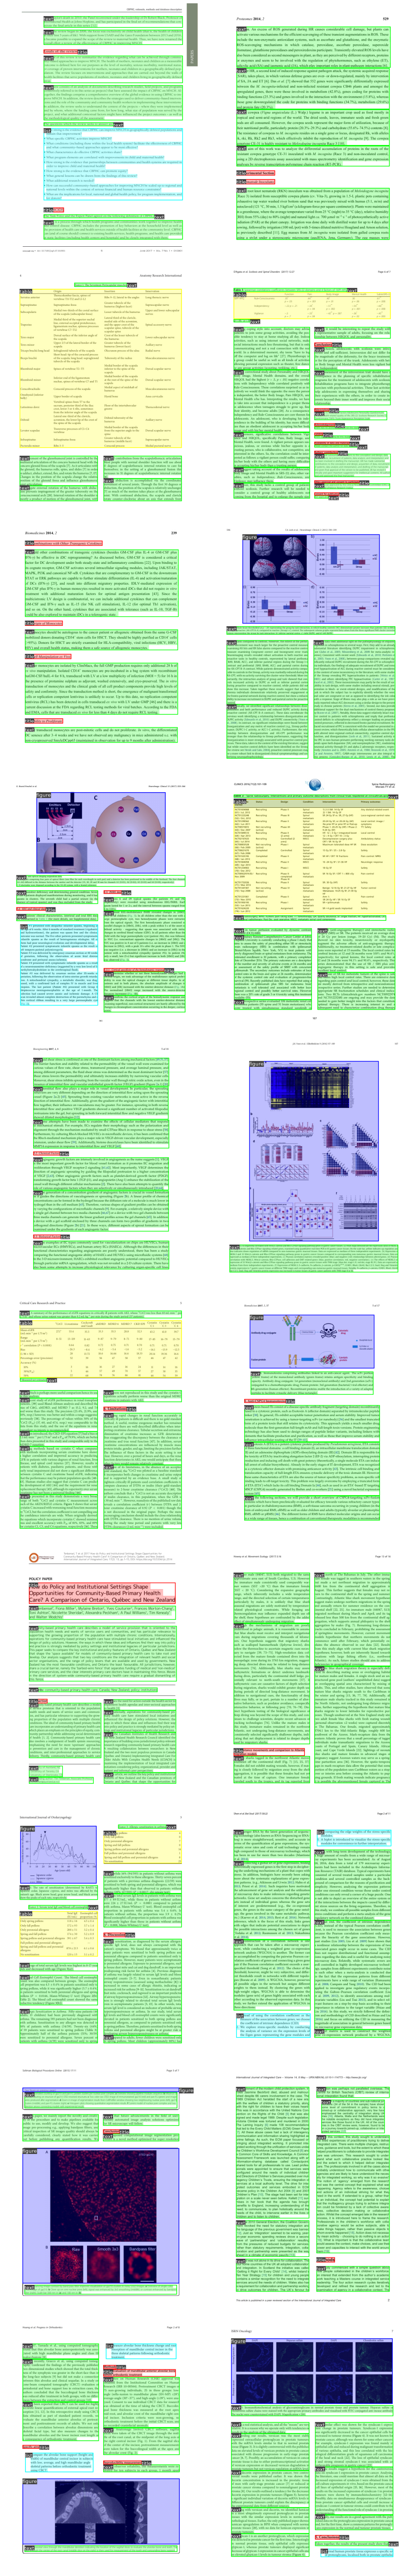

In [7]:
# Visualize annotations
font = ImageFont.truetype("examples/DejaVuSans.ttf", 15)
fig=plt.figure(figsize=(16, 100)) 
for i, (_, image) in enumerate(images.items()):
    with Image.open(image['file_name']) as img:
        ax = plt.subplot(len(images) / 2, 2, i + 1)
        ax.imshow(markup(img, image['annotations']))
        ax.axis('off')
plt.subplots_adjust(hspace=0, wspace=0)

In [8]:
import torchvision

In [9]:
#model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
model = torchvision.models.detection.faster_rcnn.FasterRCNN